In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

#### Data Generation

In [8]:
# seq values 
row_count = 500
val_count = 100
test_count =100
val_st,val_end = row_count-(val_count+test_count),row_count-test_count

data=pd.DataFrame({'seq_values':np.sin(list(range(row_count))) })
data['index'] = data.index
data.head()

,seq_values,index
0,0.000000,0
1,0.841471,1
2,0.909297,2
3,0.141120,3
4,-0.756802,4


#### Functions of model, data processing and plotting

In [313]:
def get_seq_n_tgt_data(input_df:pd.DataFrame):
    df_cpy = input_df.copy()
    df_cpy['tgt_values'] = df_cpy['seq_values'].shift(-1)
    #shiting to start the indexing from 1 onwards to align with the hidden states since h0 is random initiation
    df_cpy = df_cpy.dropna().shift(1)
    return df_cpy

def plot_pred(y_pred,y_true, title):
    plt.figure(figsize=(25,3))

    flat_pred = [pred[0][0] for pred in y_pred[1:]]
    sns.lineplot(x=range(len(flat_pred)), y=flat_pred, label='y_pred')
    sns.lineplot(x=range(len(y_true[1:])), y=y_true[1:], label='y_true')
    plt.title(title)

def rnn_forward(input_seq, target_seq, params):

    # adding None to the pred array,delta_y_arry 
    # because of the starting hidden state inorder to align the indexes in the iterations
    ht_arry, yt_pred_arry = [np.zeros_like(params['wxh'])],[None]
    delta_y_arry = [None]

    epoch_loss = 0
    
    for t_step in range(1,len(input_seq)):
        ht = np.tanh(params['ch'] + np.dot(params['whh'],ht_arry[t_step-1]) + np.dot(params['wxh'],input_seq[t_step]) )
        yt_pred = params['cy'] + np.dot(params['why'],ht )

        ht_arry.append(ht)
        yt_pred_arry.append(yt_pred)

        delta_y = target_seq[t_step]-yt_pred
        delta_y_arry.append(delta_y)
        loss = delta_y**2
        epoch_loss+=loss[0][0]

    return ht_arry, yt_pred_arry, epoch_loss, delta_y_arry


def rnn_backward(input_seq, hidden_st_array, delta_y_arry, params, l_rate):

    params_cpy = deepcopy(params)
    grads = {}
    grads['dwhy'], grads['dwxh'], grads['dwhh'] = np.zeros_like(params_cpy['why']), np.zeros_like(params_cpy['wxh']), np.zeros_like(params_cpy['whh'])
    grads['dhnext'] = np.zeros_like(hidden_st_array[-1])
    grads['dch'], grads['dcy'] = np.zeros_like(params_cpy['ch'] ), np.zeros_like(params_cpy['cy'] )
    
    #backprob through time
    for t_step in reversed(range(1,len(input_seq))):

        # derivative of squared loss
        dy = (-2)*delta_y_arry[t_step] 

        # derivative of loss w.r.t to hidden state.
        dh = np.dot(params_cpy['why'].T,dy)+ grads['dhnext']

        # derivative of loss w.r.t to the hraw where ht= tanh(hraw) : hraw = ch+ Whh*ht-1 + Wxh*xt
        dhraw = dh*(1-hidden_st_array[t_step]**2)

        # derivative of loss w.r.t to Whh
        grads['dwhh'] += np.dot(dhraw,hidden_st_array[t_step-1].T)

        # derivative of loss w.r.t to Wxh
        grads['dwxh'] += np.dot(dhraw,input_seq[t_step].reshape(-1,1).T) 

        # derivative of loss w.r.t to Why
        grads['dwhy'] += np.dot(dy,dh.T )

        #derivative of loss w.r.t to Cy
        grads['dcy'] += dy

        # derivative of loss w.r.t to Ch
        grads['dch'] += dhraw

        # derivative of loss w.r.t to the next hidden state
        grads['dhnext'] = np.dot(params_cpy['whh'].T, dhraw)

    for key in ['wxh','whh','why','cy','ch']:
        grads[f'd{key}'] = np.clip(grads[f'd{key}'], -4, 4)
        params_cpy[key]=(params_cpy[key]-l_rate*grads[f'd{key}'])

    return params_cpy

### Training and Validation

In [310]:
INPUT_SIZE = 1
HIDDEN_SIZE = 4
OUTPUT_SIZE = 1
LEARN_RATE = 0.01
EPOCHS = 20

PARAMS= {}
PARAMS['wxh'] = np.random.randn(HIDDEN_SIZE, INPUT_SIZE)
PARAMS['whh'] = np.random.randn(HIDDEN_SIZE,HIDDEN_SIZE)
PARAMS['why'] = np.random.randn(OUTPUT_SIZE,HIDDEN_SIZE)
PARAMS['ch'] = np.zeros((HIDDEN_SIZE,1))
PARAMS['cy'] = np.zeros((OUTPUT_SIZE,1))

train_data = get_seq_n_tgt_data(data.iloc[:val_st].reset_index(drop=True))
val_data = get_seq_n_tgt_data(data.iloc[val_st:val_end].reset_index(drop=True))
test_data = get_seq_n_tgt_data(data.iloc[val_end:row_count].reset_index(drop=True))

xt_trn = train_data['seq_values'].to_numpy()
yt_true_trn = train_data['tgt_values'].to_numpy()

xt_val = val_data['seq_values'].to_numpy()
yt_true_val = val_data['tgt_values'].to_numpy()

xt_test= test_data['seq_values'].to_numpy()
yt_true_test = test_data['tgt_values'].to_numpy()


# maintaining this structure so that it can be converted to a pandas dataframe
epoch_loss_tracker = {'epoch':[],'loss':[],'loss_type':[]}
for epoch in range(EPOCHS):

    # training forward pass
    ht_trn_arry, yt_trn_pred_arry, epoch_trn_loss, delta_y_trn_arry = rnn_forward(input_seq=xt_trn, 
                                                                                  target_seq=yt_true_trn, 
                                                                                  params=PARAMS)
    
    # validation forward pass
    _, yt_val_pred_arry, epoch_val_loss, _ = rnn_forward(input_seq=xt_val,
                                                         target_seq=yt_true_val,
                                                         params=PARAMS)
    epoch_loss_tracker['epoch'].append(epoch)
    epoch_loss_tracker['loss'].append(epoch_trn_loss)
    epoch_loss_tracker['loss_type'].append('train')

    epoch_loss_tracker['epoch'].append(epoch)
    epoch_loss_tracker['loss'].append(epoch_val_loss)
    epoch_loss_tracker['loss_type'].append('validation')


    print(f'epoch: {epoch} | train_cost:{epoch_trn_loss} | validation_cost: {epoch_val_loss}' )

    PARAMS = rnn_backward(input_seq=xt_trn,
                 hidden_st_array=ht_trn_arry,
                 delta_y_arry=delta_y_trn_arry,
                 params=PARAMS,
                 l_rate=LEARN_RATE)

epoch: 0 | train_cost:306.36513364944557 | validation_cost: 102.26991066043846
epoch: 1 | train_cost:233.5049682061421 | validation_cost: 78.70966187269558
epoch: 2 | train_cost:178.95489800082444 | validation_cost: 60.835277334652446
epoch: 3 | train_cost:139.95678433250282 | validation_cost: 47.79022820664318
epoch: 4 | train_cost:118.01250303562001 | validation_cost: 40.11131637905833
epoch: 5 | train_cost:76.81727078358786 | validation_cost: 26.530358671710946
epoch: 6 | train_cost:53.34589504276421 | validation_cost: 18.425928834999834
epoch: 7 | train_cost:38.77476256215452 | validation_cost: 13.393433036916404
epoch: 8 | train_cost:36.30486659059848 | validation_cost: 12.126713727351502
epoch: 9 | train_cost:29.225345721668003 | validation_cost: 9.673621110679637
epoch: 10 | train_cost:29.08273611311902 | validation_cost: 9.77946927783373
epoch: 11 | train_cost:18.259153123452673 | validation_cost: 5.524091599762755
epoch: 12 | train_cost:23.415578569919933 | validation_cost: 8.

<Axes: xlabel='epoch', ylabel='loss'>

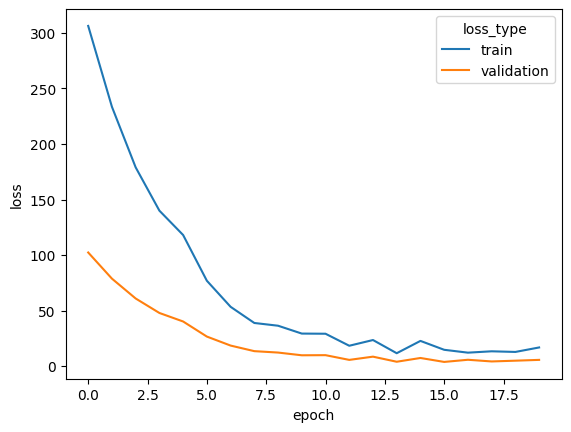

In [311]:
epoch_loss_data = pd.DataFrame(epoch_loss_tracker)


sns.lineplot(data=epoch_loss_data, x='epoch',y='loss', hue='loss_type')

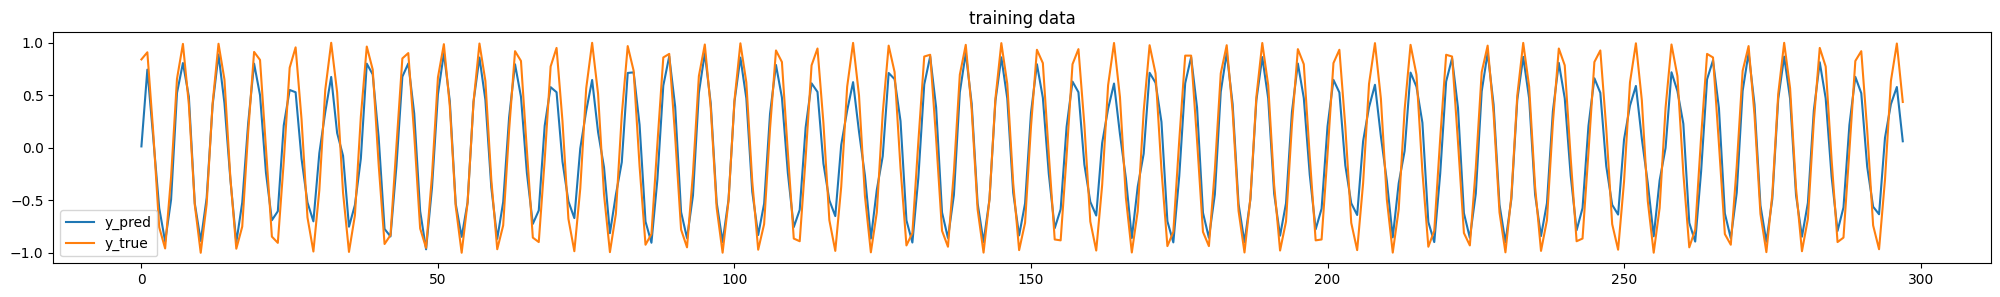

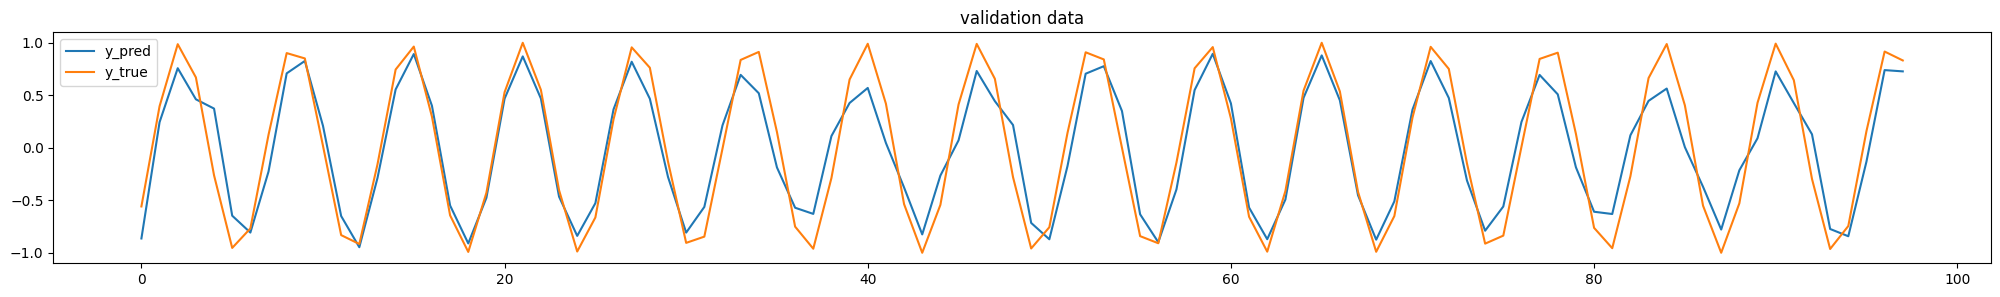

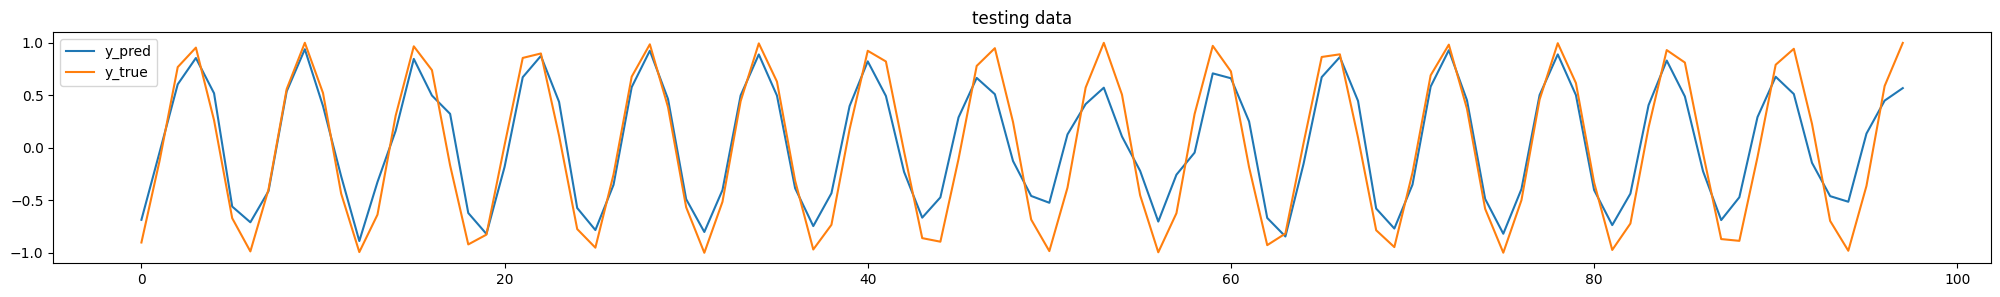

In [312]:
plot_pred(y_pred=yt_trn_pred_arry, y_true=yt_true_trn, title='training data')
plot_pred(y_pred=yt_val_pred_arry, y_true=yt_true_val, title='validation data')



_, yt_test_pred_arry, epoch_test_loss, _ = rnn_forward(input_seq=xt_test,
                                                         target_seq=yt_true_test,
                                                         params=PARAMS)

plot_pred(y_pred=yt_test_pred_arry, y_true=yt_true_test, title='testing data')